In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import seaborn as sns

# 我发现，我的分类器准确性小的可怜.....
##  后来我发现，原来一开始的特征图上的前五个特征不是数据方差太小，而是因为空值太多
##  于是为了改善模型，我将尝试填补这些特征的空值

# 空值填补

## 重新设计数据集

In [2]:
%matplotlib inline
def hist_attribute(df,bin=150):
    '''查看特征的分布情况如何'''
    plt.figure(figsize=[20,25])
    plt.title('feature distribution')
    for i in range(len(df.columns)):
        title=df.columns[i]
        plt.subplot(5,2,i+1)
        plt.hist(df.iloc[:,i].values,bins=bin)
        plt.title(title)
        plt.xlabel('value')
        plt.ylabel('count')

In [22]:
def plot_pca(num,data,label):
    pca=PCA(n_components=num)
    X_pca=pca.fit_transform(data)
    # 分割数据
    X_failure=np.array([x for i,x in enumerate(X_pca) if label[i][0]==1])
    X_healthy=np.array([x for i,x in enumerate(X_pca) if label[i][0]==0])
    
    if num==3:
        fig = plt.figure()
        ax = Axes3D(fig)   
        #ax.legend(loc='best')
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.scatter(X_failure[:,0], X_failure[:,1], X_failure[:,2])
        ax.scatter(X_healthy[:,0], X_healthy[:,1], X_healthy[:,2])
    elif num==2:
        plt.figure(figsize=[10,10])
        plt.scatter(X_failure[:,0],X_failure[:,1])
        plt.scatter(X_healthy[:,0],X_healthy[:,1])
    else:
        print('i do not want to work.....')

In [3]:
file_path='data\smart dataset sample.csv'
df=pd.read_csv(file_path)
data=df.iloc[:,3:]
X=data.iloc[:,1:]
Y=data.iloc[:,0]

# 删去特征全为空的样本
X.dropna(how='all',inplace=True)
Y=Y.iloc[X.index]

X=X.reset_index(drop=True)
Y=Y.reset_index(drop=True)

## 试试简单的填补空缺值的方法

In [4]:
# KNN回归填补空缺值
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

def knn_missing_filled(train_x,train_y,test,k=3,dispersed=True):
    if dispersed:
        clf=KNeighborsClassifier(n_neighbors=k,weights='distance',n_jobs=-1)
    else:
        clf=KNeighborsRegressor(n_neighbors=k,weights='distance',n_jobs=-1)
    clf.fit(train_x,train_y)
    return test.index,clf.predict(test)

In [5]:
# randomforest填补空缺值

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier  # 随机森林回归

def randomforest_missing_filled(train_x,train_y,test,dispersed=True):
    if dispersed:
        clf=RandomForestClassifier(n_estimators=10)
    else:
        clf=RandomForestRegressor(n_estimators=10)
    clf.fit(train_x,train_y)
    return test.index,clf.predict(test)

In [6]:
# # 一次性填补完所有特征
# def fill_feature(X_,type):
#     # 均值填补
#     if type=='mean':
#         for column in list(X_.columns[X_.isnull().sum() > 0]):
#             mean_val = X_[column].mean()
#             X_[column].fillna(mean_val, inplace=True)
#     # 众数填补
#     elif type=='mode':
#         for column in list(X_.columns[X_.isnull().sum() > 0]):
#             mean_val = X_[column].mode()
#             X_[column].fillna(mean_val, inplace=True)
#     else:
#         # 待填充的特征
#         features=['smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']
#         for i in reversed(range(len(features))):
#             # smart_198_raw的数据集
#             data_=X_.iloc[:,i:]# 完整数据（包括待预测的label）
#             fea=features[i]# 待填补特征
#             data_train=data_[data_[fea]!=0]# 训练集
#             data_test=data_[data_[fea]==0]# 测试集
#             # 训练集
#             X_train=data_train.iloc[:,1:]
#             y_train=data_train.iloc[:,0]
#             # 测试集
#             X_test=data_test.iloc[:,1:]
#             # 预测
#             ind,pred=0,0
#             if type=='knn':
#                 ind,pred=knn_missing_filled(X_train,y_train,X_test)
#             elif type=='rf':
#                 ind,pred=randomforest_missing_filled(X_train,y_train,X_test)
#             # 填补
#             X_.loc[ind,fea]=pred
#     return X_

# 一次性填补完所有特征
def fill_feature(X_,type):
    # 均值填补
    if type=='mean':
        for column in list(X_.columns[X_.isnull().sum() > 0]):
            mean_val = X_[column].mean()
            X_[column].fillna(mean_val, inplace=True)
    # 众数填补
    elif type=='mode':
        for column in list(X_.columns[X_.isnull().sum() > 0]):
            mean_val = X_[column].mode()
            X_[column].fillna(mean_val, inplace=True)
    else:
        # 待填充的特征
        features=['smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']
        for i in reversed(range(len(features))):
            # smart_198_raw的数据集
            # data_=X_.iloc[:,5:]# 完整数据（包括待预测的label）
            fea=features[i]# 待填补特征
            data_list=[X_[fea],X.iloc[:,5:]]
            data_=pd.concat(data_list,axis=1)
            data_train=data_[data_[fea]!=0]# 训练集
            data_test=data_[data_[fea]==0]# 测试集
            # 训练集
            X_train=data_train.iloc[:,1:]
            y_train=data_train.iloc[:,0]
            # 测试集
            X_test=data_test.iloc[:,1:]
            # 预测
            ind,pred=0,0
            if type=='knn':
                ind,pred=knn_missing_filled(X_train,y_train,X_test)
            elif type=='rf':
                ind,pred=randomforest_missing_filled(X_train,y_train,X_test)
            # 填补
            X_.loc[ind,fea]=pred
    return X_

In [7]:
X=fill_feature(X,type='rf')

In [37]:
X

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,0.0,0.0,0.0,0.0,0.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,0.0,0.0,2.0,0.0,0.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,0.0,0.0,0.0,0.0,0.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,0.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,0.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,0.0,4.0,0.0,0.0,0.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,0.0,0.0,0.0,0.0,0.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,0.0,0.0,0.0,0.0,0.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,0.0,0.0,0.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


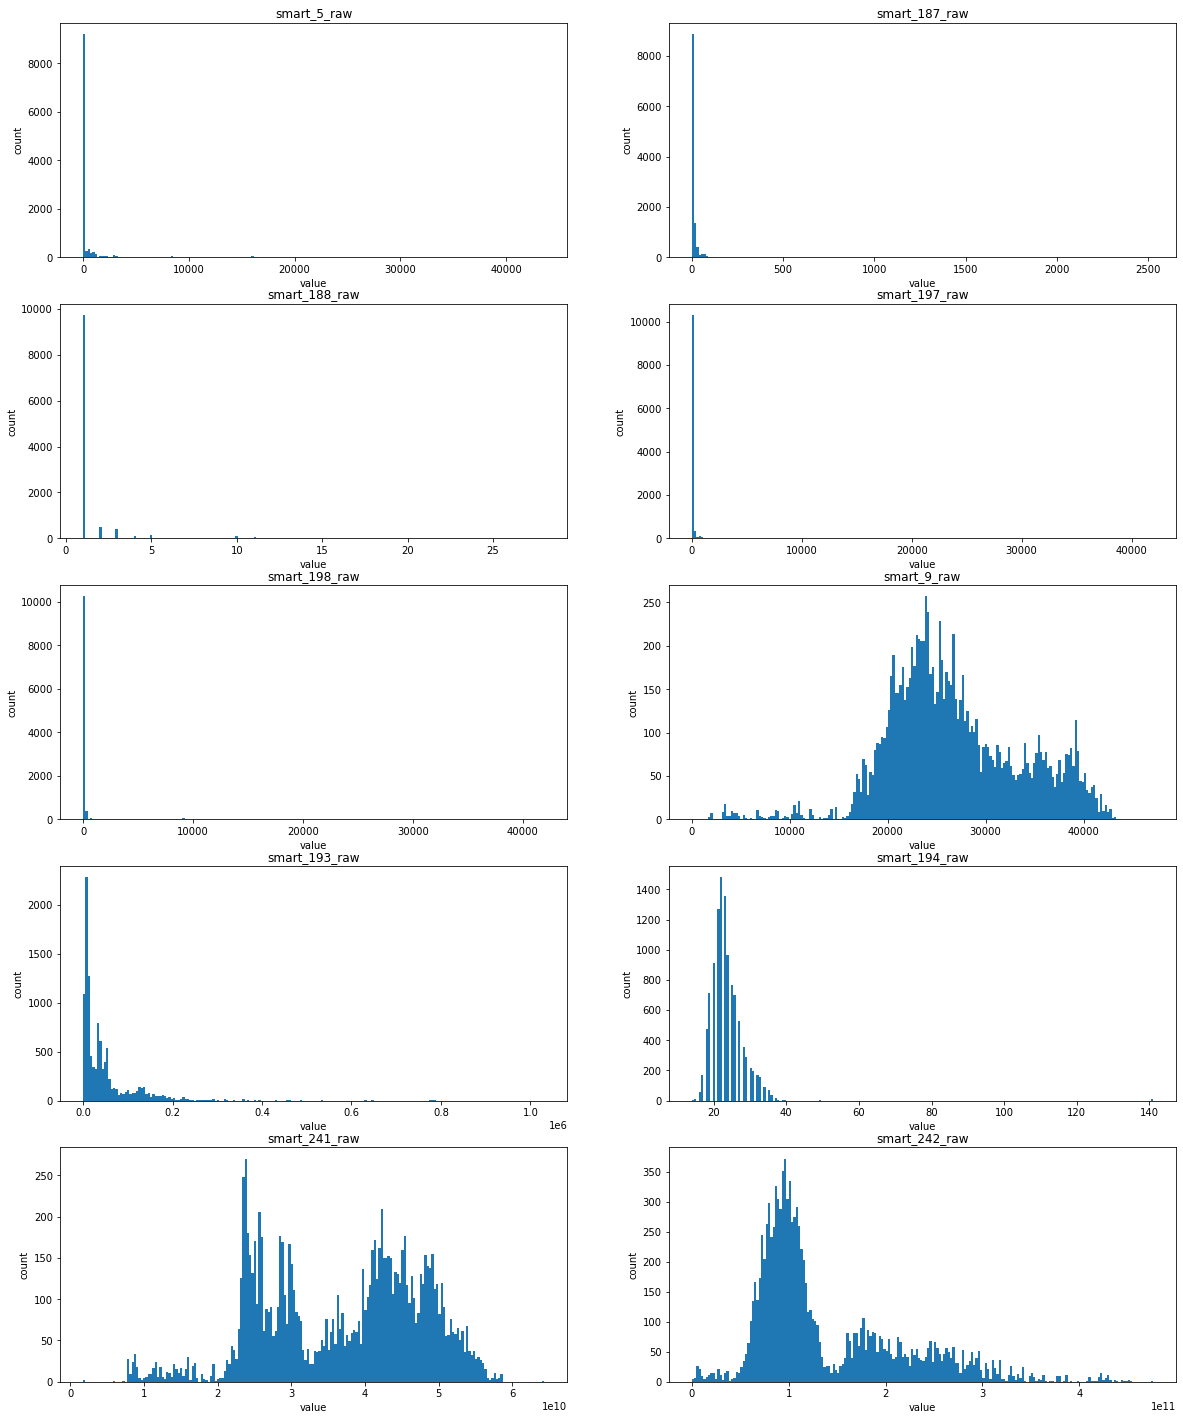

In [8]:
hist_attribute(X,bin=200)

In [37]:
# 对数优化
def all_log(X_):
    features=['smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw','smart_193_raw']
    for name in features:
        X_[name]=X_[name].apply(np.log)
    return X_
X=all_log(X)

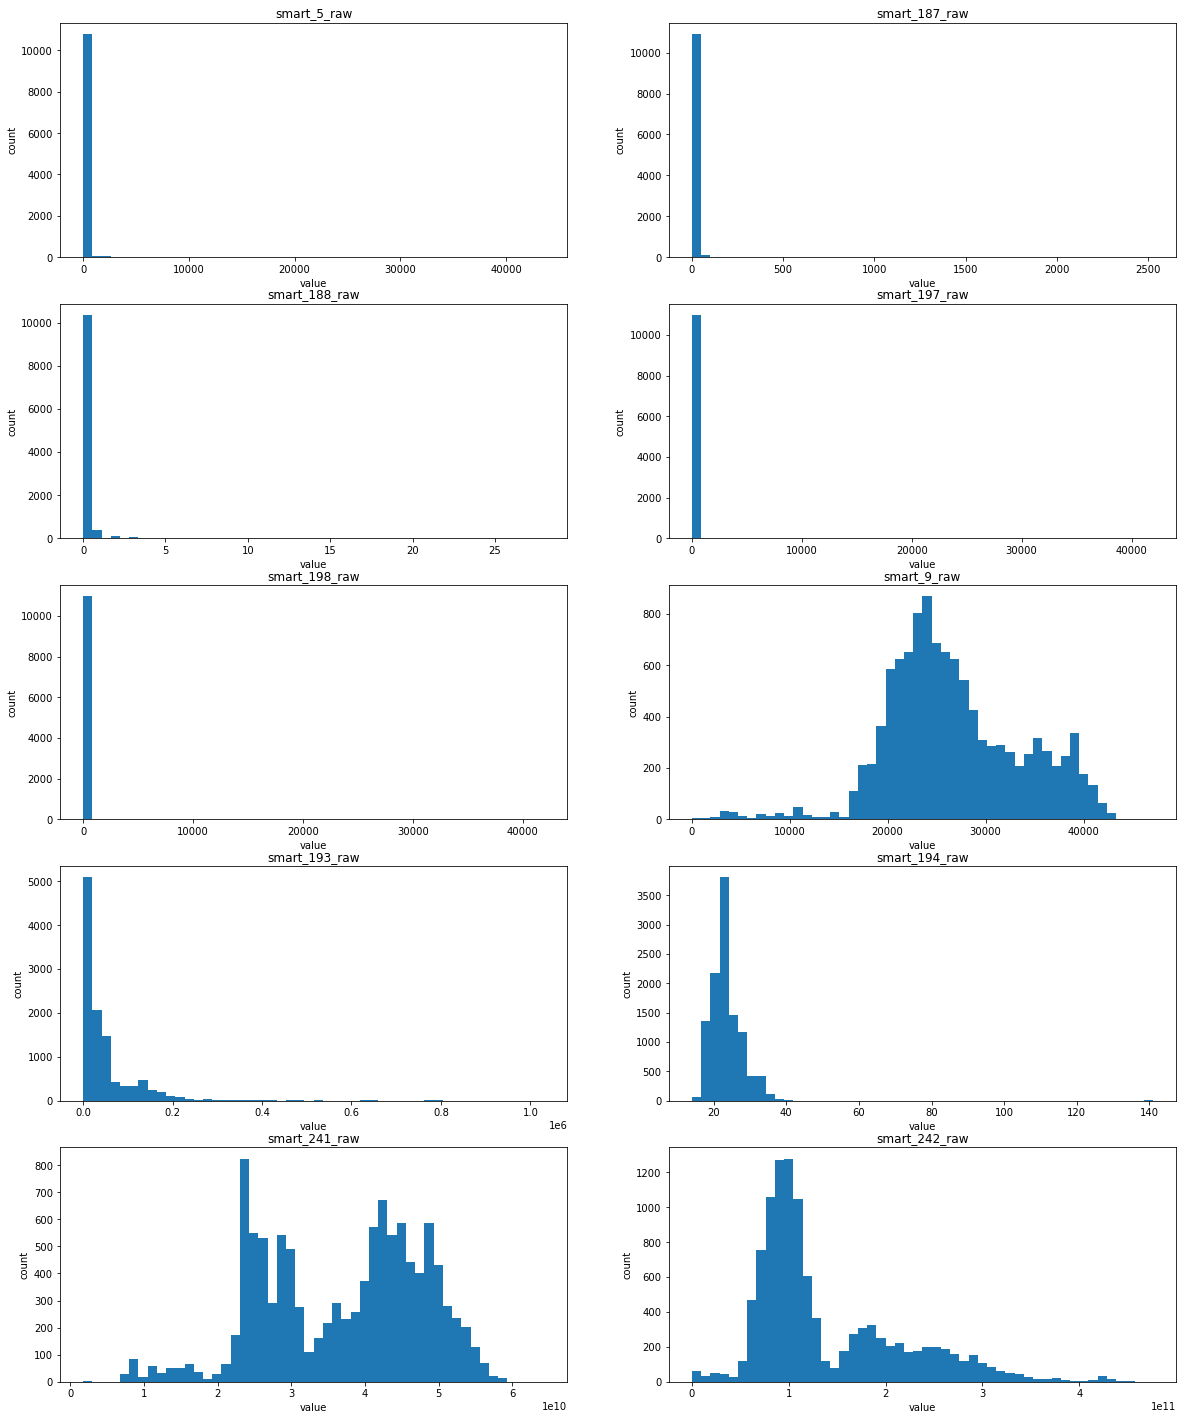

In [39]:
%matplotlib inline
hist_attribute(X,bin=50)

In [34]:
# 归一化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

# X=all_log(X)

ss=StandardScaler()
ms=MaxAbsScaler()
X_norm=ss.fit_transform(X)
# X_norm=ms.fit_transform(X)
y_norm=np.array(Y.values).reshape(-1,1)

In [48]:
X_norm

array([[-0.10181267, -0.1132566 , -0.17049237, ..., -0.68665414,
         0.64688907, -0.06465941],
       [-0.10181267, -0.1132566 ,  2.30990746, ...,  0.07023612,
        -0.9669402 ,  1.76908156],
       [-0.10181267, -0.1132566 , -0.17049237, ..., -0.49743157,
         1.62706727, -0.44731579],
       ...,
       [-0.10181267, -0.1132566 , -0.17049237, ..., -0.68665414,
        -0.94916352,  1.38427542],
       [-0.10181267, -0.1132566 , -0.17049237, ..., -0.30820901,
        -0.25374045,  3.03434915],
       [-0.00594452,  0.33621261, -0.17049237, ...,  0.07023612,
        -0.35353191,  0.72259388]])

In [55]:
# 降维可视化
%matplotlib auto
plot_pca(num=3,data=X_norm,label=y_norm)

Using matplotlib backend: Qt5Agg


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [35]:

clf_1 = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf_2 = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf_3 = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
# clf_4=svm.SVC()
# clf_4 = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#                 probability=False, tol=0.001, cache_size=200, class_weight=None, 
#                 verbose=False, max_iter=-1, decision_function_shape='ovr', 
#                 random_state=None)

scores1 = cross_val_score(clf_1, X_norm, y_norm, cv=5)
scores2 = cross_val_score(clf_2, X_norm, y_norm, cv=5)
scores3 = cross_val_score(clf_3, X_norm, y_norm, cv=5)
# scores4 = cross_val_score(clf_4, X_norm, y_norm, cv=5)

print('RandomForestClassifier scores: ',scores1.mean())
print('DecisionTreeClassifier scores: ',scores2.mean())
print('ExtraTreesClassifier scores: ',scores3.mean())
# print('SVC scores: ',scores4.mean())

RandomForestClassifier scores:  0.5475305845038514
DecisionTreeClassifier scores:  0.5467149977344812
ExtraTreesClassifier scores:  0.5249660172179429


In [89]:
# 试试神经网络分类
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import KFold

In [110]:
seed = 7
np.random.seed(seed)
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=10, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [111]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
# splitting data into training set and test set. If random_state is set to an integer, the split datasets are fixed.
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=0)

In [112]:

estimator.fit(X_train, Y_train)

In [113]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
scores5 = cross_val_score(estimator, X_norm, y_norm, cv=kfold)
print('nerulNetWork scores: ',scores5.mean())

nerulNetWork scores:  0.7644794523715973


# 目前怀疑是特征有问题，下次采取自编码神经网络来填充缺失值

##  查看特征之间的相关性

In [58]:
X

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,8.0,3.0,3.0,8.0,8.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,11248.0,30.0,2.0,48.0,48.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,8.0,9.0,1.0,24.0,24.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,336.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,1.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,8.0,4.0,1.0,104.0,104.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,22960.0,2.0,1.0,1024.0,1024.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,8.0,6.0,1.0,152.0,152.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,26056.0,42.0,3.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


<AxesSubplot:>

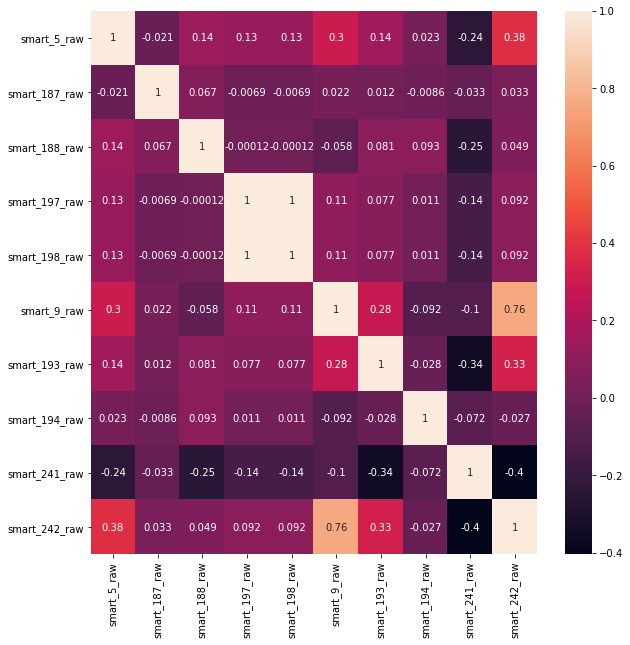

In [60]:
%matplotlib inline
complete_features=X
# 绘制热力图
plt.figure(figsize=(10,10))
sns.heatmap(complete_features.corr(),annot=True)

# 使用自编码神经网络来填补缺失值

In [59]:
X

,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_9_raw,smart_193_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,0.0,0.0,0.0,0.0,0.0,26665.0,34262.0,20.0,4.398957e+10,1.341200e+11
1,0.0,0.0,2.0,0.0,0.0,37085.0,151921.0,24.0,2.643057e+10,2.748650e+11
2,0.0,0.0,0.0,0.0,0.0,31758.0,40089.0,21.0,5.465423e+10,1.047500e+11
3,0.0,16.0,1.0,56.0,56.0,31713.0,38454.0,16.0,5.761638e+10,1.059560e+11
4,1856.0,32.0,0.0,8.0,8.0,34132.0,55556.0,19.0,5.624616e+10,1.117940e+11
...,...,...,...,...,...,...,...,...,...,...
11030,0.0,4.0,0.0,0.0,0.0,16921.0,2487.0,35.0,3.888814e+10,7.081230e+10
11031,0.0,0.0,0.0,0.0,0.0,35492.0,18589.0,22.0,3.063053e+10,2.637790e+11
11032,0.0,0.0,0.0,0.0,0.0,28148.0,85923.0,20.0,2.662399e+10,2.453300e+11
11033,0.0,0.0,0.0,40.0,40.0,39123.0,198197.0,22.0,3.419042e+10,3.719780e+11


In [12]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.objectives import mse
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.regularizers import l1_l2
from collections import defaultdict
%matplotlib inline

In [13]:
def make_reconstruction_loss(n_features):
    '''重构误差'''
    def reconstruction_loss(input_and_mask, y_pred):
        X_values = input_and_mask[:, :n_features]
        X_values.name = "$X_values"
        missing_mask = input_and_mask[:, n_features:]
        missing_mask.name = "$missing_mask"
        observed_mask = 1 - missing_mask
        observed_mask.name = "$observed_mask"
        X_values_observed = X_values * observed_mask
        X_values_observed.name = "$X_values_observed"
        pred_observed = y_pred * observed_mask
        pred_observed.name = "$y_pred_observed"
        return mse(y_true=X_values_observed, y_pred=pred_observed)
    return reconstruction_loss

In [14]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

In [15]:
class Autoencoder:
    def __init__(self, data,
                 recurrent_weight=0.5,
                 optimizer="adam",
                 dropout_probability=0.5,
                 hidden_activation="relu",
                 output_activation="sigmoid",
                 init="glorot_normal",
                 l1_penalty=0,
                 l2_penalty=0):
        self.data = data.copy()
        self.recurrent_weight = recurrent_weight
        self.optimizer = optimizer
        self.dropout_probability = dropout_probability
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.init = init
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    def _get_hidden_layer_sizes(self):
        n_dims = self.data.shape[1]
        return [
            min(2000, 8 * n_dims),
            min(500, 2 * n_dims),
            int(np.ceil(0.5 * n_dims)),
        ]
    def _create_model(self):
        hidden_layer_sizes = self._get_hidden_layer_sizes()
        first_layer_size = hidden_layer_sizes[0]
        n_dims = self.data.shape[1]
        model = Sequential()
        model.add(Dense(
            first_layer_size,
            input_dim= 2 * n_dims,
            activation=self.hidden_activation,
            W_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
            init=self.init))
        model.add(Dropout(self.dropout_probability))
        for layer_size in hidden_layer_sizes[1:]:
            model.add(Dense(
                layer_size,
                activation=self.hidden_activation,
                W_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
                init=self.init))
            model.add(Dropout(self.dropout_probability))
        model.add(Dense(
            n_dims,
            activation=self.output_activation,
            W_regularizer=l1_l2(self.l1_penalty, self.l2_penalty),
            init=self.init))
        loss_function = make_reconstruction_loss(n_dims)
        model.compile(optimizer=self.optimizer, loss=loss_function)
        return model
    def fill(self, missing_mask):
        self.data[missing_mask] = -1
    def _create_missing_mask(self):
        if self.data.dtype != "f" and self.data.dtype != "d":
            self.data = self.data.astype(float)
        return np.isnan(self.data)
    def _train_epoch(self, model, missing_mask, batch_size):
        input_with_mask = np.hstack([self.data, missing_mask])
        n_samples = len(input_with_mask)
        n_batches = int(np.ceil(n_samples / batch_size))
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_shuffled = input_with_mask[indices]
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = (batch_idx + 1) * batch_size
            batch_data = X_shuffled[batch_start:batch_end, :]
            model.train_on_batch(batch_data, batch_data)
        return model.predict(input_with_mask)
    def train(self, batch_size=256, train_epochs=100):
        missing_mask = self._create_missing_mask()
        self.fill(missing_mask)
        self.model = self._create_model()
        observed_mask = ~missing_mask
        for epoch in range(train_epochs):
            X_pred = self._train_epoch(self.model, missing_mask, batch_size)
            observed_mae = masked_mae(X_true=self.data,
                                    X_pred=X_pred,
                                    mask=observed_mask)
            if epoch % 50 == 0:
                print("observed mae:", observed_mae)
            old_weight = (1.0 - self.recurrent_weight)
            self.data[missing_mask] *= old_weight
            pred_missing = X_pred[missing_mask]
            self.data[missing_mask] += self.recurrent_weight * pred_missing
        return self.data.copy()